In [1]:
import torch
import torch.nn.functional as NF

import mitsuba
mitsuba.set_variant('cuda_ad_rgb')

import os
import sys
sys.path.append('..')

from pathlib import Path
from utils.dataset import RealDataset,SyntheticDataset
from utils.ops import *
from utils.path_tracing import ray_intersect,path_tracing

from model.brdf import NGPBRDF
from model.emitter import SLFEmitter

from tqdm import tqdm
import matplotlib.pyplot as plt

In [87]:
# brdf_path = '/proj/users/xlv/lvxin/fipt-origin/checkpoints/livingroom/cluster_part.ckpt'
brdf_path = '/proj/users/xlv/lvxin/fipt-origin/checkpoints/conferenceroom/cluster_part.ckpt'
# brdf_path = '../checkpoints/classroom/last.ckpt'
# emission file
# emitter_path = '../outputs/classroom/'
# emitter_path = '/proj/users/xlv/lvxin/fipt-origin/outputs/livingroom'
emitter_path = '/proj/users/xlv/lvxin/fipt-origin/outputs/conferenceroom'
# dataset path
# dataset_path = '/proj/users/xlv/lvxin/fipt/data/livingroom'
dataset_path = '/proj/users/xlv/lvxin/fipt/data/conferenceroom'
# dataset_path = '../data/classroom'
# dataset type
# dataset_type = 'synthetic'
dataset_type = 'real'
device = torch.device(0)

In [76]:
# load geometry
mesh_file = os.path.join(dataset_path,'scene.obj')
print(mesh_file)
assert Path(mesh_file).exists(), 'mesh file does not exist: '+mesh_file
scene = mitsuba.load_dict({
    'type': 'scene',
    'shape_id':{
        'type': 'obj',
        'filename': mesh_file, 
    },

        'sphere_1': {
        'type': 'sphere',
        'to_world': mitsuba.ScalarTransform4f\
                      # .translate([-1.78821, 1.0,-1.11344])\
                    .translate([1.78821, 0.7,3.11344])\
                      .scale([0.1,0.1,0.1]),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [1., 1., 1.]}
            }
        },
})

if dataset_type =='synthetic':
    dataset = SyntheticDataset(dataset_path,split='train',pixel=False,ray_diff=True)
elif dataset_type =='real':
    dataset = RealDataset(dataset_path,split='train',pixel=False,ray_diff=True)
print(dataset)
img_hw = dataset.img_hw
print(img_hw)

/proj/users/xlv/lvxin/fipt/data/livingroom/scene.obj
(320, 640)


In [77]:
# load brdf and emitters
mask = torch.load(os.path.join(emitter_path,'vslf.npz'),map_location='cpu')
state_dict = torch.load(brdf_path,map_location='cpu')['state_dict']
weight = {}
for k,v in state_dict.items():
    if 'material.' in k:
        weight[k.replace('material.','')]=v
material_net = NGPBRDF(mask['voxel_min'],mask['voxel_max'])
material_net.load_state_dict(weight)
material_net.to(device)
for p in material_net.parameters():
    p.requires_grad=False
    
emitter_net = SLFEmitter(os.path.join(emitter_path,'emitter.pth'),
                         os.path.join(emitter_path,'vslf.npz'))
emitter_net.to(device)
for p in emitter_net.parameters():
    p.requires_grad = False

In [82]:
spp = 10240
SPP = 128 # batch size
indir_depth=7

img_id = 15

In [83]:
batch = dataset[img_id]
rays = batch['rays'].to(device)
rays_x = rays[...,:3]
rays_d = rays[...,3:6]
dxdu,dydv = rays[...,6:9],rays[...,9:12]

In [84]:
L = torch.zeros_like(rays_x)
# process in batch to prevent memory issue
for _ in tqdm(range(spp//SPP)):
    L += path_tracing(scene,emitter_net,material_net,
                     rays_x,rays_d,
                     dxdu,dydv,
                     SPP,indir_depth=7)
L = (L.reshape(*img_hw,-1).cpu()/(spp//SPP)).numpy()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [04:41<00:00,  3.52s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 639.5, 319.5, -0.5)

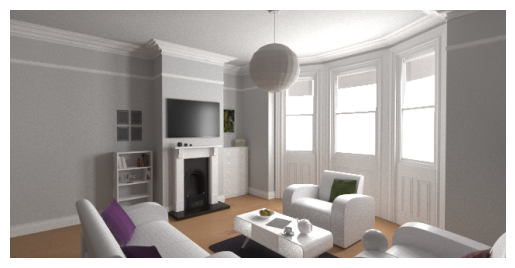

In [85]:
import numpy as np
# print(L)
plt.imshow(L**(1/2.2))
plt.axis('off')

In [86]:
import cv2
img_ = L
img_ = img_**(1/2.2)
img_ = np.clip(img_,0,1)
img_ = (img_*255).astype(np.uint8)
img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2BGR)
# print(img_)
# cv2.imwrite('fipt_relight.png',img**(1/2.2))
cv2.imwrite('object_insert_livingroom.png',img_)

True